# Code

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import numpy as np
import pickle
import math
import torch
from tqdm.notebook import tqdm
import seaborn as sns
from torch.utils.data import DataLoader
# if its_jupyter_notebook:
#     sys.argv = [''] #Remove this if it's not a jupyter notebook!

import sys
sys.path.insert(0, '..')

%load_ext autoreload
%autoreload 2
from dataset.data import (
    RNADataset,
    RNADatasetNT,
    EasyPosAugment,
    InteractionSelectionPolicy,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    SmartNegAugment,
    plot_sample,
    #plot_sample2,
    seed_everything,
)
from config import *

In [12]:
df_genes = pd.read_csv(os.path.join(processed_files_dir, "df_genes.csv"))
df = pd.read_csv(os.path.join(processed_files_dir, "final_df_RANDOM.csv"))

In [ ]:
#the N in the cdna creates problem with the tokenizer
df_genes['problematic_set'] = df_genes['cdna'].apply(lambda x: False if (set(x) - set({'A', 'C', 'G', 'T'}) == set()) else True)
genesN = set(df_genes[df_genes.problematic_set].gene_id.values)
print(f'{len(genesN)} genes have N, so will be excluded')
df = df[~(df.gene1.isin(genesN))|(df.gene2.isin(genesN))].reset_index(drop = True)

In [ ]:
with open(os.path.join(rna_rna_files_dir, 'RANDOM', f"gene_pairs_training.txt"), "rb") as fp:  # Unpickling
    subset_train = pickle.load(fp)
    subset_train = pd.Series(subset_train).str.split('_', expand = True)
    genes_train = set(subset_train[0]).union(set(subset_train[1]))

In [ ]:
limit_small_rna = 7000
limit_medium_rna = 8500

print('MAX_RNA_SIZE is', MAX_RNA_SIZE)
print('limit of small rna is:', limit_small_rna)
print('limit of medium rna is:', limit_medium_rna)

small1 = df[(df.length_2<=limit_small_rna)&(df.length_1<=limit_medium_rna)] #both small and one small the other medium
small2 = df[(df.length_1<=limit_small_rna)&(df.length_2<=limit_medium_rna)] #both small and one small the other medium
df_small = pd.concat([small1, small2], axis = 0).drop_duplicates()

df_big = df[(df.length_1>limit_medium_rna)&(df.length_2>limit_medium_rna)]

big_small_idx = list(df_small.index) + list(df_big.index) 
df_medium = df.loc[set(df.index) - set(big_small_idx)]

assert (df_small.shape[0]+df_medium.shape[0]+df_big.shape[0]) == df.shape[0]
assert set(df_big.couples).union(df_medium.couples).union(df_small.couples) == set(df.couples)

df_small = df_small.reset_index(drop=True)
df_medium = df_medium.reset_index(drop=True)
df_big = df_big.reset_index(drop=True)


set(df_small.couples).union(set(df_medium.couples)).union(set(df_big.couples)) == set(df.couples)
perc_small = np.round(df_small.shape[0]/df.shape[0]*100, 1)
perc_medium = np.round(df_medium.shape[0]/df.shape[0]*100, 1)
perc_big = np.round(df_big.shape[0]/df.shape[0]*100, 1)
print(f'The amount of contact matrixes (in the entire dataset) that are small is {perc_small}% ')
print(f'The amount of contact matrixes (in the entire dataset) that are medium is {perc_medium}% ')
print(f'The amount of contact matrixes (in the entire dataset) that are big is {perc_big}% ')

In [ ]:
def create_sample_dict(id_couple, sample):
    """
    x1, x2, y1, y2 is where is the interaction with respect to the actual coordinates (not the original coordinates)
    length_1, length_2 is the length with respect to the actual length (not the original length)
    
    original_x1, original_x2, original_y1, original_y2 is where the rna interacts with respect to original coordinates 
    window_x1, window_x2, window_y1, window_y2 is where the rna was sampled with respect to original coordinates 
    original_length1, original_length2 is the original length
    """
    d = {
        'id_sample':id_couple,
        'couples':sample.couple_id,
        'gene1':sample.gene1,
        'gene2':sample.gene2,
        'interacting':sample.interacting,
        'length_1':sample.bbox.x2-sample.bbox.x1,
        'length_2':sample.bbox.y2-sample.bbox.y1,
        'protein_coding_1':sample.gene1_info["protein_coding"],
        'protein_coding_2':sample.gene2_info["protein_coding"],
        'x1': sample.seed_interaction_bbox.x1 - sample.bbox.x1,
        'x2': sample.seed_interaction_bbox.x2 - sample.bbox.x1,
        'y1': sample.seed_interaction_bbox.y1 - sample.bbox.y1,
        'y2': sample.seed_interaction_bbox.y2 - sample.bbox.y1,
        'policy':sample.policy,
        'cdna1':sample.gene1_info["cdna"][sample.bbox.x1:sample.bbox.x2],
        'cdna2':sample.gene2_info["cdna"][sample.bbox.y1:sample.bbox.y2],
        'original_x1':sample.seed_interaction_bbox.x1,
        'original_x2':sample.seed_interaction_bbox.x2,
        'original_y1':sample.seed_interaction_bbox.y1,
        'original_y2':sample.seed_interaction_bbox.y2,
        'window_x1':sample.bbox.x1,
        'window_x2':sample.bbox.x2,
        'window_y1':sample.bbox.y1,
        'window_y2':sample.bbox.y2,
        'original_length1':len(sample.gene1_info["cdna"]),
        'original_length2':len(sample.gene2_info["cdna"]),
        'id_gene1_sample':sample.gene1 + '_' + str(sample.bbox.x1) + '_' + str(sample.bbox.x2),
        'id_gene2_sample':sample.gene2 + '_' + str(sample.bbox.y1) + '_' + str(sample.bbox.y2)
    }
    return d

def get_dataset(ep_per_sample, sn_per_sample, en_persample, hn_per_sample, df_genes, df, subset_file, pos_width_multipliers, pos_height_multipliers, neg_width_windows, neg_height_windows):
    assert np.round(sum(pos_width_multipliers.values()), 4) == np.round(sum(neg_width_windows.values()), 4) == 1
    
    pol = []
    
    if ep_per_sample>0:
        pol.append(
            EasyPosAugment(
            per_sample=ep_per_sample,
            interaction_selection=InteractionSelectionPolicy.LARGEST,
            width_multipliers=pos_width_multipliers,
            height_multipliers=pos_height_multipliers,
            )
        )
        
    if sn_per_sample>0:
        pol.append(   
            SmartNegAugment(
                per_sample=sn_per_sample,
                interaction_selection=InteractionSelectionPolicy.LARGEST,
                width_multipliers=pos_width_multipliers,
                height_multipliers=pos_height_multipliers,
            )
        )
        
    if en_persample>0:
        pol.append( 
            EasyNegAugment(
                per_sample=en_persample,
                width_windows=neg_width_windows,
                height_windows=neg_height_windows,
            )
        )
        
    if hn_per_sample>0:
        pol.append(
            HardNegAugment(
                per_sample=hn_per_sample,
                width_windows=neg_width_windows,
                height_windows=neg_height_windows,
            )
        )
        
    dataset = RNADataset(
            gene2info=df_genes,
            interactions=df,
            subset_file=subset_file,
            augment_policies=pol,
    )
    return dataset 

In [ ]:
pos_width_multipliers = {1_000_000: 1.}
pos_height_multipliers = pos_width_multipliers
neg_width_windows = {(MAX_RNA_SIZE-1, MAX_RNA_SIZE): float(1),}
neg_height_windows = neg_width_windows

In [ ]:
#small policies
ep_per_sample_small=1
sn_per_sample_small=0
en_per_sample_small=1
hn_per_sample_small=1

#medium policies
ep_per_sample_medium=2
sn_per_sample_medium=0
en_per_sample_medium=1
hn_per_sample_medium=1


#big policies
ep_per_sample_big=3
sn_per_sample_big=0
en_per_sample_big=2
hn_per_sample_big=2

In [9]:
tot_ep = ep_per_sample_small*perc_small + ep_per_sample_medium*perc_medium + ep_per_sample_big*perc_big
tot_sn = sn_per_sample_small*perc_small + sn_per_sample_medium*perc_medium + sn_per_sample_big*perc_big
tot_en = en_per_sample_small*perc_small + en_per_sample_medium*perc_medium + en_per_sample_big*perc_big
tot_hn = hn_per_sample_small*perc_small + hn_per_sample_medium*perc_medium + hn_per_sample_big*perc_big

tot_neg = tot_sn + tot_en + tot_hn
print(f'expected smartneg are the {np.round( tot_sn/tot_neg *100, 2)}% of negative pairs')
print(f'expected easyneg are the {np.round( tot_en/tot_neg *100, 2)}% of negative pairs')
print(f'expected hardneg are the {np.round( tot_hn/tot_neg *100, 2)}% of negative pairs')

unbalanced_factor = df[df.interacting == False].shape[0]/df.shape[0]
expected_uf = tot_ep*unbalanced_factor / ((tot_ep*unbalanced_factor) + tot_neg)
print(f'expected unbalanced factor is {np.round(expected_uf*100, 2)}%')

expected smartneg are the 0.0% of negative pairs
expected easyneg are the 50.0% of negative pairs
expected hardneg are the 50.0% of negative pairs
expected unbalanced factor is 29.14%


# Data loader train

In [10]:
set_data = 'training' 
assert set_data in ['training', 'val', 'test']
subset_file = os.path.join(rna_rna_files_dir, 'RANDOM', f"gene_pairs_training.txt")

id_couple = 0
meta = {}

In [11]:
#sample.all_couple_interactions

In [12]:
start_time = time.time()

small = get_dataset(ep_per_sample=ep_per_sample_small, sn_per_sample=sn_per_sample_small, 
                    en_persample=en_per_sample_small, hn_per_sample=hn_per_sample_small, 
                    df_genes=df_genes, df=df_small, subset_file=subset_file, 
                    pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                    neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(small), total = len(small)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
medium = get_dataset(ep_per_sample=ep_per_sample_medium, sn_per_sample=sn_per_sample_medium,
                     en_persample=en_per_sample_medium, hn_per_sample=hn_per_sample_medium, 
                     df_genes=df_genes, df=df_medium, subset_file=subset_file,
                     pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                     neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(medium), total = len(medium)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
big = get_dataset(ep_per_sample=ep_per_sample_big, sn_per_sample=sn_per_sample_big, 
                  en_persample=en_per_sample_big, hn_per_sample=hn_per_sample_big, 
                  df_genes=df_genes, df=df_big, subset_file=subset_file, 
                  pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                  neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(big), total = len(big)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
def df_meta_from_meta_dict(meta, do_controls = True):
    df_meta = pd.DataFrame.from_dict(meta, 'index')
    df_meta['lencdna1'] = df_meta.apply(lambda x: len(x.cdna1), axis = 1)
    df_meta['lencdna2'] = df_meta.apply(lambda x: len(x.cdna2), axis = 1)
    if do_controls:
        assert (df_meta['lencdna1'] == df_meta['length_1']).all()
        assert (df_meta['lencdna2'] == df_meta['length_2']).all()
        assert ((df_meta.window_x2 - df_meta.window_x1)==(df_meta.lencdna1)).all()
        assert ((df_meta.window_y2 - df_meta.window_y1)==(df_meta.lencdna2)).all()
    df_meta = df_meta.drop(['lencdna1', 'lencdna2'], axis = 1)
    if do_controls:
        m = df_meta[df_meta.policy.isin({'smartneg', 'easypos'})]
        assert (m.x1 >= 0).all()
        assert (m.y1 >= 0).all()
        assert (m.x2 <= m.length_1).all()
        assert (m.y2 <= m.length_2).all()

        assert df_meta[df_meta.length_1==df_meta.original_length1][['gene1', 'id_gene1_sample']].groupby('gene1').nunique().max().iloc[0] == 1
        assert df_meta[df_meta.length_2==df_meta.original_length2][['gene2', 'id_gene2_sample']].groupby('gene2').nunique().max().iloc[0] == 1
    return df_meta

df_meta = df_meta_from_meta_dict(meta, do_controls = False)
print(f"Total time to create datasets: {(time.time()-start_time)/60} minutes")

  0%|          | 0/174545 [00:00<?, ?it/s]

  0%|          | 0/65349 [00:00<?, ?it/s]

  0%|          | 0/9312 [00:00<?, ?it/s]

Total time to create datasets: 38.007661588986714 minutes


14814 20771
0.7132059120889702
easyneg


/data01/giorgio/RNARNA-NT/src/../dataset/data.py:1325: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot([0, width],[0, height], 'ro', color = 'white')


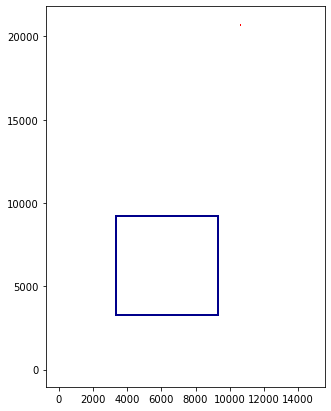

In [13]:
plot_sample(sample, True)
print(sample.policy)

### Controllo se alcuni geni hanno un arricchimento solo nei positivi o solo nei negativi.

In [14]:
def balance_df(df):
    positives = df[df.interacting]
    negatives = df[df.interacting == False]
    if negatives.shape[0]>=positives.shape[0]:
        negatives_to_sample = positives.shape[0]
        df_sampled = pd.concat([positives, negatives.sample(negatives_to_sample)],axis = 0)
    else:
        positives_to_sample = negatives.shape[0]
        df_sampled = pd.concat([negatives, positives.sample(positives_to_sample)],axis = 0)
    return df_sampled.reset_index(drop = True)

def obtain_pair_diff_distribution(sampled, gene_count_real):
    sampled = sampled.merge(gene_count_real[['gene', 'diff']], left_on = 'gene1', right_on = 'gene').drop('gene', axis = 1).rename({'diff':'diff1'}, axis =1)
    sampled = sampled.merge(gene_count_real[['gene', 'diff']], left_on = 'gene2', right_on = 'gene').drop('gene', axis = 1).rename({'diff':'diff2'}, axis =1)
    sampled['diff'] = sampled['diff1'] + sampled['diff2']
    return sampled

def obtain_gene_count_real(df):
    vc = df.interacting.value_counts()
    if set(vc.index) == {False, True}:
        unbalance_factor = vc[True]/vc[False]
    else:
        unbalance_factor = np.nan
    gene_count_pos_list = list(df[df.interacting].gene1) + list(df[df.interacting].gene2)
    gene_count_neg_list = list(df[df.interacting == False].gene1) + list(df[df.interacting == False].gene2)

    gene_count_pos = pd.DataFrame({'gene': gene_count_pos_list, 'interacting':1})
    gene_count_neg = pd.DataFrame({'gene': gene_count_neg_list, 'interacting':0})
    gene_count_res = pd.concat([gene_count_pos, gene_count_neg], axis = 0)
    
    gene_count_res['weight'] = 1
    gene_count_res.loc[ gene_count_res.interacting == 0, 'weight'] = unbalance_factor
    gene_count_real = gene_count_res.groupby('gene').sum()
    gene_count_real['not_interacting'] = gene_count_real['weight'] - gene_count_real['interacting']
    gene_count_real['diff'] = gene_count_real['interacting'] - gene_count_real['not_interacting']
    gene_count_real['total'] = gene_count_real['not_interacting'] + gene_count_real['interacting']
    gene_count_real = gene_count_real.reset_index()#add gene column
    return gene_count_real

In [15]:
gene_count = obtain_gene_count_real(df_meta)
df_meta = obtain_pair_diff_distribution(df_meta, gene_count)

In [16]:
print(df_meta.shape[0])

249206


#### Simulate

  0%|          | 0/30 [00:00<?, ?it/s]

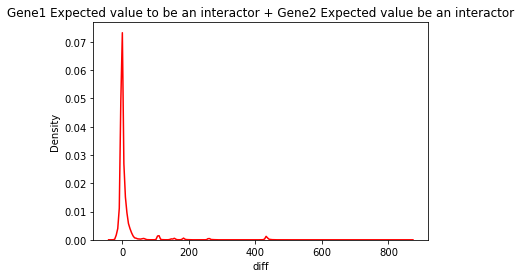

In [17]:
n_epochs = 30
couples = []
interactings = []
for i in tqdm(range(n_epochs)):
    train_sampled = balance_df(df_meta.copy().drop(['diff1', 'diff2', 'diff'], axis = 1))
    couples += list(train_sampled.couples)
    interactings += list(train_sampled.interacting)

res = pd.DataFrame({'couples':couples, 'interactings':interactings})
new_cols = res.couples.str.extractall('(.*)_(.*)')
res['gene1'] = new_cols.reset_index()[0]
res['gene2'] = new_cols.reset_index()[1]

gene_count_pos_list = list(res[res.interactings].gene1) + list(res[res.interactings].gene2)
gene_count_neg_list = list(res[res.interactings == False].gene1) + list(res[res.interactings == False].gene2)
gene_count_pos = pd.DataFrame({'gene': gene_count_pos_list, 'interacting':1})
gene_count_neg = pd.DataFrame({'gene': gene_count_neg_list, 'interacting':0})
gene_count_res = pd.concat([gene_count_pos, gene_count_neg], axis = 0)
gene_count_res['n'] = 1
gene_count_real = gene_count_res.groupby('gene').sum()
gene_count_real['not_interacting'] = gene_count_real['n'] - gene_count_real['interacting']
gene_count_real['diff'] = gene_count_real['interacting'] - gene_count_real['not_interacting']
gene_count_real = gene_count_real.reset_index()

res = obtain_pair_diff_distribution(res, gene_count_real)

sns.kdeplot(res['diff']/n_epochs, color = 'red', label = 'empirical')
plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor')
plt.show()

In [18]:
df_meta = df_meta_from_meta_dict(meta, do_controls = False)

In [19]:
tot_ep = (df_meta.policy == 'easypos').sum()
tot_sn = (df_meta.policy == 'smartneg').sum()
tot_en = (df_meta.policy == 'easyneg').sum()
tot_hn = (df_meta.policy == 'hardneg').sum()
tot_neg = (df_meta.interacting == False).sum()
assert tot_ep == (df_meta.interacting == True).sum()
assert tot_neg == tot_en+tot_sn+tot_hn
print(f'actual smartneg are the {np.round( tot_sn/tot_neg *100, 2)}% of negative pairs')
print(f'actual easyneg are the {np.round( tot_en/tot_neg *100, 2)}% of negative pairs')
print(f'actual hardneg are the {np.round( tot_hn/tot_neg *100, 2)}% of negative pairs')

print(f'actual unbalanced factor is {np.round( (tot_ep/(tot_ep+tot_neg))*100, 2)}%')

actual smartneg are the 0.0% of negative pairs
actual easyneg are the 66.49% of negative pairs
actual hardneg are the 33.51% of negative pairs
actual unbalanced factor is 29.34%


In [20]:
assert (df_meta.id_gene1_sample.str.extract('(.*)_(.*)_(.*)')[0] == df_meta.gene1).all()
assert (df_meta.id_gene2_sample.str.extract('(.*)_(.*)_(.*)')[0] == df_meta.gene2).all()

In [21]:
#drop sequences that are too short
min_length = 30
print('n to drop: ', df_meta[(df_meta.length_1<min_length)|(df_meta.length_2<min_length)].shape[0])

df_meta = df_meta[ ~ (
    (df_meta.length_1<min_length)|(df_meta.length_2<min_length)
)]

n to drop:  19


In [22]:
df_meta.to_csv(os.path.join(metadata_dir, 'RANDOM', f'{set_data}_easy.csv'), index = False)

# Data Loader val

In [23]:
#small policies
ep_per_sample_small=1
sn_per_sample_small=0
en_per_sample_small=1
hn_per_sample_small=1

#medium policies
ep_per_sample_medium=2
sn_per_sample_medium=0
en_per_sample_medium=1
hn_per_sample_medium=1


#big policies
ep_per_sample_big=3
sn_per_sample_big=0
en_per_sample_big=2
hn_per_sample_big=2

In [24]:
set_data = 'val' 
assert set_data in ['training', 'val', 'test']
subset_file = os.path.join(rna_rna_files_dir, 'RANDOM', f"gene_pairs_{set_data}.txt")

meta = {}

In [25]:
start_time = time.time()

small = get_dataset(ep_per_sample=ep_per_sample_small, sn_per_sample=sn_per_sample_small, 
                    en_persample=en_per_sample_small, hn_per_sample=hn_per_sample_small, 
                    df_genes=df_genes, df=df_small, subset_file=subset_file, 
                    pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                    neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(small), total = len(small)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
medium = get_dataset(ep_per_sample=ep_per_sample_medium, sn_per_sample=sn_per_sample_medium,
                     en_persample=en_per_sample_medium, hn_per_sample=hn_per_sample_medium, 
                     df_genes=df_genes, df=df_medium, subset_file=subset_file,
                     pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                     neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(medium), total = len(medium)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
big = get_dataset(ep_per_sample=ep_per_sample_big, sn_per_sample=sn_per_sample_big, 
                  en_persample=en_per_sample_big, hn_per_sample=hn_per_sample_big, 
                  df_genes=df_genes, df=df_big, subset_file=subset_file, 
                  pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                  neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(big), total = len(big)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
df_meta = pd.DataFrame.from_dict(meta, 'index')
df_meta['lencdna1'] = df_meta.apply(lambda x: len(x.cdna1), axis = 1)
df_meta['lencdna2'] = df_meta.apply(lambda x: len(x.cdna2), axis = 1)
assert (df_meta['lencdna1'] == df_meta['length_1']).all()
assert (df_meta['lencdna2'] == df_meta['length_2']).all()
assert ((df_meta.window_x2 - df_meta.window_x1)==(df_meta.lencdna1)).all()
assert ((df_meta.window_y2 - df_meta.window_y1)==(df_meta.lencdna2)).all()
df_meta = df_meta.drop(['lencdna1', 'lencdna2'], axis = 1)

m = df_meta[df_meta.policy.isin({'smartneg', 'easypos'})]
assert (m.x1 >= 0).all()
assert (m.y1 >= 0).all()
assert (m.x2 <= m.length_1).all()
assert (m.y2 <= m.length_2).all()

assert df_meta[df_meta.length_1==df_meta.original_length1][['gene1', 'id_gene1_sample']].groupby('gene1').nunique().max().iloc[0] == 1
assert df_meta[df_meta.length_2==df_meta.original_length2][['gene2', 'id_gene2_sample']].groupby('gene2').nunique().max().iloc[0] == 1

print(f"Total time to create datasets: {(time.time()-start_time)/60} minutes")

  0%|          | 0/33247 [00:00<?, ?it/s]

  0%|          | 0/12929 [00:00<?, ?it/s]

  0%|          | 0/1856 [00:00<?, ?it/s]

Total time to create datasets: 6.850482229391734 minutes


In [26]:
df_meta.to_csv(os.path.join(metadata_dir, 'RANDOM', f'{set_data}_easy.csv'), index = False)

I have to undersample df_meta because I want a balanced validation set.

In [27]:
df_meta = pd.read_csv(os.path.join(metadata_dir, 'RANDOM', f'{set_data}_easy.csv'))

In [28]:
#undersample df_meta

subset_file = os.path.join(rna_rna_files_dir, 'RANDOM', f"gene_pairs_{set_data}_HQ.txt")
with open(subset_file, "rb") as fp:  # Unpickling
    subset_val_HQ = pickle.load(fp)
    
df_meta = df_meta[df_meta.couples.isin(subset_val_HQ)]

if df_meta.interacting.value_counts()[False] >= df_meta.interacting.value_counts()[True]:
    n_to_exclude = df_meta.interacting.value_counts()[False] - df_meta.interacting.value_counts()[True]
    df_to_sample = df_meta[(df_meta.gene1.isin(genes_train))&(df_meta.gene2.isin(genes_train))&(df_meta.interacting == False)]
else:
    n_to_exclude = df_meta.interacting.value_counts()[True] - df_meta.interacting.value_counts()[False]
    df_to_sample = df_meta[(df_meta.gene1.isin(genes_train))&(df_meta.gene2.isin(genes_train))&(df_meta.interacting == True)]
    
ids_to_eclude = set(df_to_sample.sample(frac = 1).head(n_to_exclude).id_sample)
df_meta = df_meta[~df_meta.id_sample.isin(ids_to_eclude)]
assert np.isclose(1, df_meta.interacting.value_counts()[True]/df_meta.interacting.value_counts()[False])
df_meta = df_meta.reset_index(drop = True)

df_meta.to_csv(os.path.join(metadata_dir, 'RANDOM', f'{set_data}_sampled_easy.csv'), index = False)

# Create the embedding query

In [2]:
#import data 
train = pd.read_csv(os.path.join(metadata_dir, 'RANDOM', f'training_easy.csv'))
val = pd.read_csv(os.path.join(metadata_dir, 'RANDOM', f'val_sampled_easy.csv'))

In [3]:
def create_query_df(df):
    df1 = df[['id_gene1_sample', 'cdna1']].drop_duplicates().rename({'id_gene1_sample':'id_query', 'cdna1':'cdna'}, axis = 1)
    df2 = df[['id_gene2_sample', 'cdna2']].drop_duplicates().rename({'id_gene2_sample':'id_query', 'cdna2':'cdna'}, axis = 1)
    df = pd.concat([df1, df2], axis = 0).drop_duplicates().reset_index(drop = True)
    return df

In [4]:
train_query = create_query_df(train)
val_query = create_query_df(val)
df_query = pd.concat([train_query, val_query], axis = 0).drop_duplicates().reset_index(drop = True)
del train_query
del val_query

query_train = set(train['id_gene1_sample']).union(set(train['id_gene2_sample']))
query_val = set(val['id_gene1_sample']).union(set(val['id_gene2_sample']))
query = set(query_train).union(query_val)

#the 2 assert below also means that there are unique cdna per id_query
assert len(df_query.id_query) == len(query)
assert set(df_query.id_query) == query

In [5]:
all_files = os.listdir(os.path.join(embedding_dir, '32'))
all_files = list(pd.Series(all_files).str.extractall('(.*)\.npy').reset_index()[0])
df_query = df_query[~df_query.id_query.isin(all_files)]

In [6]:
df_query.to_csv(os.path.join(metadata_dir, 'embedding_query.csv'), index = False)

In [7]:
def estimate_time_and_space(n_samples):
    #TIME
    minutes = 3219*n_samples/(228278)
    hours = minutes/60
    days = hours/24
    print('estimated # hours:', np.round(hours, 2))
    print('estimated # days:', np.round(days, 2))

    mb = 10.2*n_samples
    gb = mb/1000
    tb = gb/1000
    print('estimated terabytes (pessimistic):', np.round(tb, 2))
    mb = 1995*n_samples/(300)
    gb = mb/1000
    tb = gb/1000
    print('estimated terabytes (realistic):', np.round(tb, 2))
estimate_time_and_space(df_query.shape[0])

estimated # hours: 27.21
estimated # days: 1.13
estimated terabytes (pessimistic): 1.18
estimated terabytes (realistic): 0.77


In [ ]:
def get_directory_size(directory):
    total_size = 0
    n_files = 0
    # Walk through all the files and subdirectories in the directory
    for path, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(path, file)
            total_size += os.stat(file_path).st_size
            n_files+=1

    # Convert the size to a human-readable format
    size_in_bytes = total_size
    size_in_kilobytes = total_size / 1000
    size_in_megabytes = size_in_kilobytes / 1000
    size_in_gigabytes = size_in_megabytes / 1000
    size_in_terabytes = size_in_gigabytes / 1000

    return {
        "n_files":n_files,
        # "bytes": size_in_bytes,
        # "kilobytes": size_in_kilobytes,
        # "megabytes": size_in_megabytes,
        "gigabytes": size_in_gigabytes, 
        "terabytes": size_in_terabytes, 
    }

# Usage example
directory_path = os.path.join(embedding_dir)
directory_size = get_directory_size(directory_path)
print(directory_size)

# Create df_genes_nt and df_nt

In [2]:
#import data 
train = pd.read_csv(os.path.join(metadata_dir, 'RANDOM', f'training_easy.csv'))

val = pd.read_csv(os.path.join(metadata_dir, 'RANDOM',  f'val_sampled_easy.csv'))

In [3]:
def swap_if_needed(df):
    df['actual_couples'] = df.gene1 + '_' + df.gene2
    df['need_to_swap'] = df.couples!=df.actual_couples
    where = df.need_to_swap
    df.loc[where, ['gene1', 'gene2']] = (df.loc[where, ['gene2', 'gene1']].values)
    df.loc[where, ['length_1', 'length_2']] = (df.loc[where, ['length_2', 'length_1']].values)
    df.loc[where, ['protein_coding_1', 'protein_coding_2']] = (df.loc[where, ['protein_coding_2', 'protein_coding_1']].values)
    df.loc[where, ['x1', 'y1']] = (df.loc[where, ['y1', 'x1']].values)
    df.loc[where, ['x2', 'y2']] = (df.loc[where, ['y2', 'x2']].values)
    df.loc[where, ['cdna1', 'cdna2']] = (df.loc[where, ['cdna2', 'cdna1']].values)
    df.loc[where, ['original_x1', 'original_y1']] = (df.loc[where, ['original_y1', 'original_x1']].values)
    df.loc[where, ['original_x2', 'original_y2']] = (df.loc[where, ['original_y2', 'original_x2']].values)
    df.loc[where, ['window_x1', 'window_y1']] = (df.loc[where, ['window_y1', 'window_x1']].values)
    df.loc[where, ['window_x2', 'window_y2']] = (df.loc[where, ['window_y2', 'window_x2']].values)
    df.loc[where, ['original_length1', 'original_length2']] = (df.loc[where, ['original_length2', 'original_length1']].values)
    df.loc[where, ['id_gene1_sample', 'id_gene2_sample']] = (df.loc[where, ['id_gene2_sample', 'id_gene1_sample']].values)
    if ('diff1' in df.columns)&('diff2' in df.columns):
        df.loc[where, ['diff1', 'diff2']] = (df.loc[where, ['diff2', 'diff1']].values)
    df['actual_couples'] = df.gene1 + '_' + df.gene2
    assert (df.couples==df.actual_couples).all()
    return df.drop(['need_to_swap', 'actual_couples'], axis = 1)

In [4]:
train = swap_if_needed(train)
val = swap_if_needed(val)

In [5]:
assert len(set(train.id_sample)) == len(train)
assert len(set(val.id_sample)) == len(val)

assert set(val.id_sample).intersection(set(train.id_sample)) == set()

In [6]:
train['couples_id'] = train['couples']
train['couples'] = train['id_sample']

val['couples_id'] = val['couples']
val['couples'] = val['id_sample']

# export subsets

with open(os.path.join(rna_rna_files_dir, 'RANDOM', f"gene_pairs_training_nt_easy.txt"), "wb") as fp:   #Pickling
    pickle.dump(list(set(train.couples)), fp)

with open(os.path.join(rna_rna_files_dir, 'RANDOM', f"gene_pairs_val_sampled_nt_easy.txt"), "wb") as fp:   #Pickling
    pickle.dump(list(set(val.couples)), fp)

print('train:', len(list(set(train.couples))))
print('val:', len(list(set(val.couples))))

train: 249187
val: 10890


##### Create fake_interaction_region

In [7]:
#create fake_interaction_region
interaction_size= 16

def create_fake_interaction_region(df, interaction_size=16):
    subset = df[df.policy.isin(['hardneg', 'easyneg'])]
    
    length1_values = subset['length_1'].values - interaction_size
    length2_values = subset['length_2'].values - interaction_size

    # Generate random indices within the length1 range
    x1_indices = np.random.randint(0, length1_values, size=len(subset))
    x2_indices = x1_indices + interaction_size  # Ensure a distance of interaction_size between x1 and x2

    # Generate random indices within the length2 range
    y1_indices = np.random.randint(0, length2_values, size=len(subset))
    y2_indices = y1_indices + interaction_size  # Ensure a distance of interaction_size between y1 and y2
    
    df.loc[df.policy.isin(['hardneg', 'easyneg']), 'x1'] = x1_indices
    df.loc[df.policy.isin(['hardneg', 'easyneg']), 'x2'] = x2_indices
    df.loc[df.policy.isin(['hardneg', 'easyneg']), 'y1'] = y1_indices
    df.loc[df.policy.isin(['hardneg', 'easyneg']), 'y2'] = y2_indices
    return df


train = create_fake_interaction_region(train)
val = create_fake_interaction_region(val)

assert (train.x2<=train.length_1).all()
assert (val.x2<=val.length_1).all()

assert (train.x1>=0).all()
assert (val.x1>=0).all()

subset = train[train.policy.isin(['hardneg', 'easyneg'])]
assert ((subset.x2-subset.x1) == interaction_size).all()
subset = val[val.policy.isin(['hardneg', 'easyneg'])]
assert ((subset.x2-subset.x1) == interaction_size).all()

In [8]:
df_full = pd.concat([train, val], axis = 0)
df_full = df_full.rename({'gene1':'gene1_id', 'gene2':'gene2_id'}, axis = 1)
df_full = df_full.rename({'id_gene1_sample':'gene1', 'id_gene2_sample':'gene2'}, axis = 1)

In [9]:
df_nt = df_full.copy()
df_nt['w'] = df_nt['x2'] - df_nt['x1']
df_nt['h'] = df_nt['y2'] - df_nt['y1']
column_order = ['couples','gene1','gene2','interacting',
                'length_1','length_2','protein_coding_1','protein_coding_2',
                'x1','y1','w','h', 'policy',
                'original_x1','original_x2',
                'original_y1','original_y2',
                'id_gene1_sample','id_gene2_sample', 'couples_id',
               ]
df_nt = df_nt.drop_duplicates(subset = [
    'couples','gene1','gene2','interacting',
    'length_1','length_2','protein_coding_1',
    'protein_coding_2','x1','y1','w','h',
    'policy','original_x1','original_x2',
    'original_y1','original_y2','couples_id'
]).reset_index(drop = True)
df_nt = df_nt.filter(column_order, axis = 1)
#crea coordinate per easyneg e hardneg
df_nt.to_csv(os.path.join(metadata_dir, 'RANDOM', f'df_nt_easy.csv'), index = False)

In [10]:
column_order = [
    'gene1','gene2','id_gene1_sample','id_gene2_sample',
    'original_length1','original_length2', 'cdna1', 'cdna2',
    'window_x1','window_x2','window_y1','window_y2', 
    'gene1_id', 'gene2_id', 'protein_coding_1',  'protein_coding_2'
]

df_g = df_full.filter(column_order, axis = 1)

df_g1 = df_g.filter(
    [
    'gene1', 
    'id_gene1_sample', 
    'cdna1', 
    'window_x1',
    'window_x2', 
    'gene1_id',
    'protein_coding_1', 
    'length_1',
    'original_length1', 
    ]
).rename(
    {
    'gene1':'gene_id',
    'cdna1':'cdna', 
    'length_1':'length',
    'window_x1':'window_c1',
    'window_x2':'window_c2',
    'gene1_id':'original_gene_id', 
    'protein_coding_1':'protein_coding', 
    'original_length1':'original_length'
    }, 
    axis = 1)
df_g2 = df_g.filter(
    [
    'gene2', 
    'id_gene2_sample', 
    'cdna2', 
    'window_y1',
    'window_y2', 
    'gene2_id',
    'protein_coding_2', 
    'length_2',
    'original_length2', 
    ]
).rename(
    {
    'gene2':'gene_id',
    'cdna2':'cdna', 
    'length_2':'length',
    'window_y1':'window_c1',
    'window_y2':'window_c2',
    'gene2_id':'original_gene_id', 
    'protein_coding_2':'protein_coding', 
    'original_length2':'original_length'
    }, 
    axis = 1)

df_genes_nt = pd.concat([df_g1, df_g2], axis = 0).drop_duplicates().reset_index(drop = True)

df_genes_nt['UTR5'] = 0
df_genes_nt['CDS'] = 0
df_genes_nt['UTR3'] = 0

In [13]:
assert set(df_genes_nt.original_gene_id) - set(df_genes.gene_id) == set()
assert set(train.gene1).union(train.gene2).union(val.gene1).union(val.gene2) - set(df.gene1).union(df.gene2) == set()
assert set(df_full.gene1_id).union(df_full.gene2_id) - set(df.gene1).union(df.gene2) == set()

In [14]:
df_genes_nt.to_csv(os.path.join(metadata_dir, 'RANDOM', f'df_genes_nt_easy.csv'), index = False)